# Exploratory Data Analysis

#### We load in our data, reshape and merge

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [ ]:
basics = pd.read_csv(r"C:/Users/jungn/OneDrive/Documents/movie project/title.basics.tsv.gz", sep = "\t", compression = "gzip", na_values="\\N")
ratings = pd.read_csv(r"C:/Users/jungn/OneDrive/Documents/movie project/title.ratings.tsv.gz", sep = "\t", compression = "gzip")

C:\Users\jungn\AppData\Local\Temp\ipykernel_18396\3868304171.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  basics = pd.read_csv(r"C:/Users/jungn/OneDrive/Documents/movie project/title.basics.tsv.gz", sep = "\t", compression = "gzip", na_values="\\N")


#### from the IMDB dataset we only want movies (between 1980-2022), so we exclude tv shows, videos etc

In [ ]:
movies = basics[(basics["titleType"] == "movie") & (basics["startYear"].between(1980, 2022))]
[["tconst", "primaryTitle", "startYear", "runtimeMinutes", "genres"]]

[['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres']]

#### We now merge the movies data and ratings data based on "tconst" which is the unique movie ID

In [ ]:
movies = movies.merge(ratings, on="tconst", how="left")

#### Load in the principals data 

In [ ]:
principals = pd.read_csv(r"C:/Users/jungn/OneDrive/Documents/movie project/title.principals.tsv.gz", sep="\t", na_values="\\N")

#### We get the director count and cast size

In [ ]:
principals = principals[principals["category"].isin(["director", "actor", "actress"])]

In [ ]:
director_counts = (principals[principals["category"] == "director"]
    .groupby("tconst")
    .size()
    .rename("num_directors")
    .reset_index()
)

In [ ]:
cast_size = (principals[principals["category"].isin(["actor", "actress"])]
    .groupby("tconst")
    .size()
    .rename("cast_size")
    .reset_index()
)

In [ ]:
movies = (movies
    .merge(director_counts, on="tconst", how="left")
    .merge(cast_size, on="tconst", how="left")
)


In [ ]:
movies[["num_directors", "cast_size"]] = (movies[["num_directors", "cast_size"]].fillna(0))


#### Convert into a csv file 

In [ ]:
movies.to_csv("C:/Users/jungn/OneDrive/Documents/movie project/movies_features.csv", index=False)


In [ ]:
films = pd.read_csv("C:/Users/jungn/OneDrive/Documents/movie project/movies_features.csv")

In [ ]:
films

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,num_directors,cast_size
0,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019.0,NaN,NaN,"Action,Crime",NaN,NaN,1.0,10.0
1,tt0015724,movie,Dama de noche,Dama de noche,0,1993.0,NaN,102.0,"Drama,Mystery,Romance",6.2,35.0,1.0,10.0
2,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118.0,"Comedy,Fantasy,Romance",6.4,92914.0,1.0,10.0
3,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",0,1983.0,NaN,118.0,"Drama,War",6.4,379.0,1.0,10.0
4,tt0038086,movie,Shiva und die Galgenblume,Shiva und die Galgenblume,0,1993.0,NaN,NaN,Thriller,7.0,30.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395550,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015.0,NaN,57.0,Documentary,NaN,NaN,1.0,1.0
395551,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007.0,NaN,100.0,Documentary,NaN,NaN,1.0,0.0
395552,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013.0,NaN,NaN,Comedy,7.7,9.0,1.0,10.0
395553,tt9916730,movie,6 Gunn,6 Gunn,0,2017.0,NaN,116.0,Drama,7.0,13.0,1.0,8.0


#### Now we move on to some exploring

In [ ]:
# Total NaN count:
films.isna().any(axis=1).sum()


np.int64(395555)

In [ ]:
# Which columns have NaNs and how many?
films.isna().sum().sort_values(ascending=False)


endYear           395555
averageRating     168946
numVotes          168946
runtimeMinutes     89259
genres             30256
primaryTitle           2
originalTitle          2
tconst                 0
titleType              0
isAdult                0
startYear              0
num_directors          0
cast_size              0
dtype: int64

Above, we see that numVotes and averageRating have the same number of NaNs which means they are missing together. Movies without an IMDB rating is an indication that they are very obscure, and since this project is about how a movie ages in audience pereption these will not serve any purpose so they can be dropped.

In [ ]:
films = films.dropna(subset = ["averageRating", "numVotes"])
films = films.dropna(subset = ["primaryTitle"])
# drop the 2 primaryTitle NaNs as it is a negligible amount

I have decided to keep the rest (genres, runtimeMinutes) as they are still important and will prevent potential bias towards mainstream cinema.

#### Handling runtime NaNs:

In [ ]:
films["runtime_missing"] = films["runtimeMinutes"].isna().astype(int)
films["runtimeMinutes"] = films["runtimeMinutes"].fillna(films["runtimeMinutes"].median())
# Create a new column indicating which rows were NaNs as an integer (0,1) 
# Replace missing values with median runtime of the dataset (mean is not as robust when it comes to extreme values or outliers)

#### Handling genre NaNs:

In [ ]:
films["genres"] = films["genres"].fillna("Unknown") # Replace NaN with Unknown
films["has_genre_info"] = (films["genres"] != "Unknown").astype(int) # Column: Genre info exists, 1. Genre info does not exist, 0.

In [ ]:
films = films.drop("endYear", axis=1)

In [ ]:
films.isna().sum()

tconst             0
titleType          0
primaryTitle       0
originalTitle      0
isAdult            0
startYear          0
runtimeMinutes     0
genres             0
averageRating      0
numVotes           0
num_directors      0
cast_size          0
runtime_missing    0
has_genre_info     0
dtype: int64

In [ ]:
films

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,num_directors,cast_size,runtime_missing,has_genre_info
1,tt0015724,movie,Dama de noche,Dama de noche,0,1993.0,102.0,"Drama,Mystery,Romance",6.2,35.0,1.0,10.0,0,1
2,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,118.0,"Comedy,Fantasy,Romance",6.4,92914.0,1.0,10.0,0,1
3,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",0,1983.0,118.0,"Drama,War",6.4,379.0,1.0,10.0,0,1
4,tt0038086,movie,Shiva und die Galgenblume,Shiva und die Galgenblume,0,1993.0,92.0,Thriller,7.0,30.0,1.0,10.0,1,1
5,tt0038687,movie,Let There Be Light,Let There Be Light,0,1980.0,58.0,"Documentary,War",7.5,2147.0,0.0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395547,tt9916362,movie,Coven,Akelarre,0,2020.0,92.0,"Drama,History,Horror",6.4,6167.0,1.0,10.0,0,1
395548,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019.0,92.0,"Adventure,History,War",4.7,23.0,1.0,10.0,1,1
395549,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019.0,123.0,Drama,7.6,12.0,1.0,10.0,0,1
395552,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013.0,92.0,Comedy,7.7,9.0,1.0,10.0,1,1


- What make a movie a "classic"?
- Given the data:
    - High ratings
    - High review counts
- These are a good indication of "well known" or "famous"

We will explore how many movies in the dataset have an average rating of 7.5 or higher:

In [ ]:
films[films.averageRating >= 7.5].shape[0]

41555

Let's see how many of these movies have review counts in the thousands:

In [ ]:
films.loc[(films["averageRating"] >= 7.5) & (films["numVotes"] >= 1000)].shape[0]

3846

1000 seems a bit arbitrary. We could argue that 500 is a good amount of reviews or 1000 is not enough.

In [ ]:
high = films.loc[films["averageRating"] >= 7.5]

In [ ]:
high["numVotes"].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

0.10       9.0
0.25      13.0
0.50      24.0
0.75      72.0
0.90     782.6
0.95    5409.4
Name: numVotes, dtype: float64

Above, we see that the top 10% of movies in terms of number of votes with average ratings 7.5 and above have around 782 votes or more. 

In [ ]:
films.loc[(films["averageRating"] >= 7.5) & (films["numVotes"] >= 782)].shape[0]

4159

We now have 4159 movies we could call "classics" as they have high ratings **and** a high number of votes 

What about non-classics which were well recieved at the time of release?
some indications could be:
- high ratings 
- low review count 

One reason for movies not aging well could be that they were following a popular trend at the time such as genre.

In [ ]:
genres = films[["startYear", "genres"]].copy()

In [ ]:
genres["genres"] = genres["genres"].str.split(",")

In [ ]:
genres = genres.explode("genres")

In [ ]:
genrecount = genres.groupby(["startYear","genres"]).size().reset_index(name="count")

In [ ]:
top_genres = (
    genrecount
    .groupby("genres")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(8)
    .index
)

genrecount = genrecount[genrecount["genres"].isin(top_genres)]


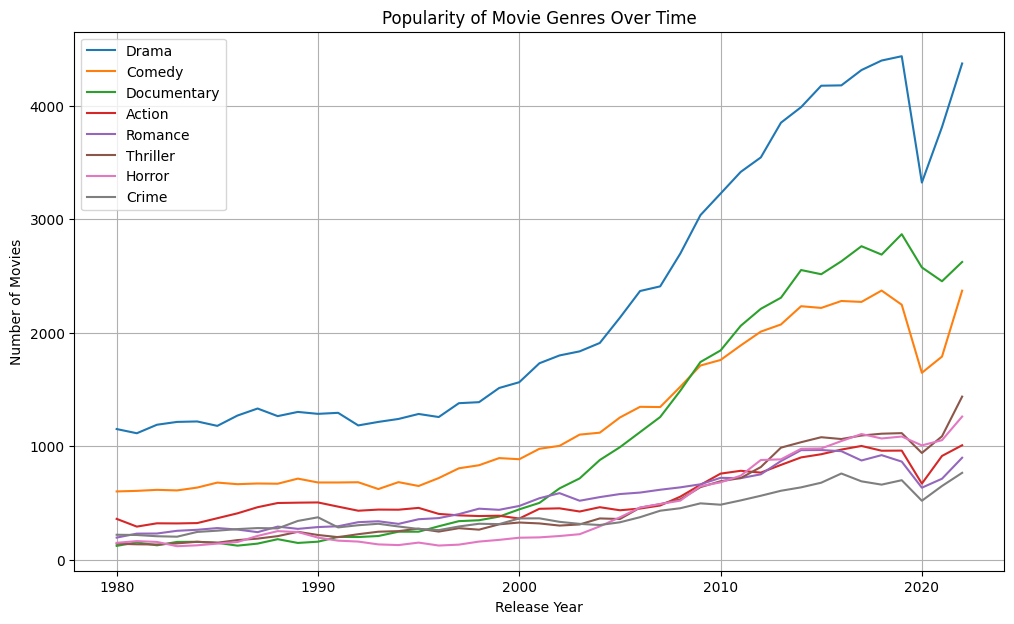

In [ ]:
plt.figure(figsize=(12,7))

for genre in top_genres:
    subset = genrecount[genrecount["genres"] == genre]
    plt.plot(subset["startYear"], subset["count"], label=genre)

plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.title("Popularity of Movie Genres Over Time")
plt.legend()
plt.grid(True)
plt.show()

we see that drama has been a popular genre since the 80s, which means a large share of movies released then was following that trend. (It's also interesting to see when the coronavirus hit the film industry the hardest.)

In [ ]:
#Let's take a look at movies with the "drama" genre

drama = films[(films["genres"] == "Drama") & (films["averageRating"] >= 7.5) & (films["numVotes"] >= 782) ]
drama

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,num_directors,cast_size,runtime_missing,has_genre_info
121,tt0078868,movie,Confidence,Bizalom,0,1980.0,105.0,Drama,7.5,1179.0,1.0,10.0,0,1
127,tt0078894,movie,Good Riddance,Les bons débarras,0,1980.0,120.0,Drama,8.0,815.0,1.0,10.0,0,1
324,tt0080341,movie,In Search of Famine,Akaler Sandhane,0,1981.0,115.0,Drama,7.6,2057.0,1.0,9.0,0,1
942,tt0081283,movie,Ordinary People,Ordinary People,0,1980.0,124.0,Drama,7.7,60875.0,1.0,10.0,0,1
1534,tt0082280,movie,Muddy River,Doro no kawa,0,1981.0,105.0,Drama,7.8,1157.0,1.0,10.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391991,tt9581076,movie,"So Long, My Son",Di jiu tian chang,0,2019.0,185.0,Drama,7.7,5963.0,1.0,10.0,0,1
392183,tt9602804,movie,The Last Color,The Last Color,0,2019.0,90.0,Drama,7.7,1017.0,1.0,10.0,0,1
392223,tt9610262,movie,Chaal Jeevi Laiye,Chaal Jeevi Laiye,0,2019.0,137.0,Drama,8.7,1854.0,1.0,10.0,0,1
392793,tt9660502,movie,Close,Close,0,2022.0,104.0,Drama,7.8,45774.0,1.0,10.0,0,1


At a glance, we immediately see a lot of movies that aren't well known despite having higher review counts. One obvious factor is the region the film was produced, as some regions do not have much as much exposure to a global audience compared to others. 

This brings up another important point: Classics can vary by region. For example if you ask someone here in Melbourne if they are familiar with the movie "Chaal Jeevi Laiye" (8.7 rating, 1854 vote count) despite being popular and well known in India you'll most likely get a blank stare. Say you do ask an indian person, they would still need to be fluent in Gujarati as that is the spoken language in the film.

In [ ]:
drama = films[(films["genres"] == "Drama") & (films["averageRating"] >= 7.5) & (films["numVotes"] <= 500) ]
drama

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,num_directors,cast_size,runtime_missing,has_genre_info
120,tt0078860,movie,Bietul Ioanide,Bietul Ioanide,0,1980.0,135.0,Drama,7.5,138.0,1.0,11.0,0,1
201,tt0079421,movie,Troubled Laughter,Ku nao ren de xiao,0,1981.0,92.0,Drama,7.6,56.0,2.0,10.0,0,1
202,tt0079424,movie,Két történet a félmúltból,Két történet a félmúltból,0,1980.0,106.0,Drama,7.8,9.0,1.0,6.0,0,1
734,tt0080941,movie,Jadup und Boel,Jadup und Boel,0,1988.0,100.0,Drama,7.6,87.0,1.0,10.0,0,1
895,tt0081211,movie,A mérközés,A mérközés,0,1981.0,105.0,Drama,7.9,49.0,1.0,10.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395339,tt9898368,movie,Langit Tidak Selalu Cerah,Langit Tidak Selalu Cerah,0,1981.0,90.0,Drama,8.4,10.0,1.0,6.0,0,1
395361,tt9900388,movie,Hansa: Ek Sanyog,Hansa Ek Sanyog,0,2019.0,135.0,Drama,9.2,19.0,2.0,10.0,0,1
395363,tt9900398,movie,Love Lives Here,Love Lives Here,0,2019.0,94.0,Drama,7.5,75.0,1.0,10.0,0,1
395504,tt9911774,movie,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,0,2019.0,130.0,Drama,9.3,381.0,1.0,5.0,0,1


Going back to the "following a trend" idea, we see plenty of examples with high ratings but low vote counts which suggests that trend may definitely an important factor in predicting whether a movie will become a classic or will be forgotten.

**To keep things simple, we will consider all movies with ratings 7.5 and above with vote counts 782 and above "classics"**

In [ ]:
high["numVotes"].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

0.10       9.0
0.25      13.0
0.50      24.0
0.75      72.0
0.90     782.6
0.95    5409.4
Name: numVotes, dtype: float64

Here we see that the bottom 10% of movies in terms of number of votes with average ratings 7.5 and above have around 9 votes or more. 

In [ ]:
films.loc[(films["averageRating"] >= 7.5) & (films["numVotes"] <= 9)].shape[0]
#There are 5546 movies that were successful ratings wise, but the low number of vote counts suggests that it was/is not popular.

5546

**We will consider these movies as "forgotten"**

To predict whether a movie will be a "Classic" or "Forgotten", we need to see their characteristics.

**"Classics":**

In [ ]:
Classic = films[(films["averageRating"] >= 7.5) & (films["numVotes"] >= 782)]
Classic

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,num_directors,cast_size,runtime_missing,has_genre_info
5,tt0038687,movie,Let There Be Light,Let There Be Light,0,1980.0,58.0,"Documentary,War",7.5,2147.0,0.0,1.0,0,1
20,tt0067625,movie,Trial on the Road,Proverka na dorogakh,0,1986.0,96.0,"Drama,War",7.8,2807.0,1.0,10.0,0,1
51,tt0076276,movie,Who's Singin' Over There?,Ko to tamo peva,0,1980.0,86.0,"Adventure,Comedy,Drama",8.7,17661.0,1.0,10.0,0,1
93,tt0078349,movie,Swan Lake,Sekai meisaku dôwa: Hakuchô no mizûmi,0,1981.0,75.0,"Adventure,Animation,Family",7.6,1055.0,1.0,10.0,0,1
121,tt0078868,movie,Confidence,Bizalom,0,1980.0,105.0,Drama,7.5,1179.0,1.0,10.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394787,tt9851854,movie,Major,Major,0,2022.0,150.0,"Action,Biography,Drama",8.1,33920.0,1.0,10.0,0,1
395138,tt9881586,movie,Rascal Does Not Dream of a Dreaming Girl,Seishun buta yaro wa yumemiru shoujo no yume w...,0,2019.0,89.0,"Animation,Drama,Fantasy",8.3,9091.0,1.0,10.0,0,1
395154,tt9882084,movie,Chasing Happiness,Chasing Happiness,0,2019.0,96.0,"Biography,Documentary,Music",7.7,2386.0,1.0,0.0,0,1
395186,tt9883832,movie,Moonage Daydream,Moonage Daydream,0,2022.0,135.0,"Biography,Documentary,Music",7.6,16142.0,1.0,0.0,0,1


**"Forgotten:"**

In [ ]:
Forgotten = films[(films["averageRating"] >= 7.5) & (films["numVotes"] <= 9)]
Forgotten

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,num_directors,cast_size,runtime_missing,has_genre_info
202,tt0079424,movie,Két történet a félmúltból,Két történet a félmúltból,0,1980.0,106.0,Drama,7.8,9.0,1.0,6.0,0,1
328,tt0080349,movie,All About a Prima Ballerina,All About a Prima Ballerina,0,1980.0,92.0,Unknown,8.0,7.0,1.0,3.0,1,0
555,tt0080679,movie,Fundi: The Story of Ella Baker,Fundi: The Story of Ella Baker,0,1981.0,63.0,Documentary,8.3,9.0,1.0,0.0,0,1
751,tt0080965,movie,Joe Albany... a Jazz Life,Joe Albany... a Jazz Life,0,1980.0,57.0,Documentary,7.8,9.0,1.0,1.0,0,1
1856,tt0082725,movie,"Max Frisch, Journal I-III","Max Frisch, Journal I-III",0,1981.0,122.0,Documentary,8.6,7.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395231,tt9889918,movie,2 Friends,2 Friends,0,2018.0,134.0,"Comedy,Drama,Romance",7.8,8.0,1.0,10.0,0,1
395265,tt9891882,movie,Elements Quest,Elements Quest,0,2017.0,92.0,"Comedy,Fantasy",8.2,7.0,1.0,11.0,1,1
395357,tt9900050,movie,Duniya Khatam Ho Rahi Hai,Duniya Khatam Ho Rahi Hai,0,2017.0,110.0,Comedy,8.6,8.0,1.0,5.0,0,1
395360,tt9900354,movie,Anak Sulung Tujuh Keturunan,Anak Sulung Tujuh Keturunan,0,1982.0,110.0,"Action,Drama",8.2,9.0,1.0,10.0,0,1


In [ ]:
films["num_genres"] = films["genres"].str.count(",") + 1

Classic and forgotten refer to audience engagement, not quality.

Let's compare genre presence and genre diversity. We'll compute the genre frequency within each group and normalise to proportions. This will answer the question: "Are classics overrepresented in certain genres?"

Splitting genres into a list:

In [ ]:
classic_genres = Classic[["tconst", "genres"]].copy()
forgotten_genres = Forgotten[["tconst", "genres"]].copy()

In [ ]:
classic_genres["genres"] = classic_genres["genres"].str.split(",")
forgotten_genres["genres"] = forgotten_genres["genres"].str.split(",")

In [ ]:
classic_genres = classic_genres.explode("genres")
forgotten_genres = forgotten_genres.explode("genres")

In [ ]:
classic_genres

,tconst,genres
5,tt0038687,Documentary
5,tt0038687,War
20,tt0067625,Drama
20,tt0067625,War
51,tt0076276,Adventure
...,...,...
395186,tt9883832,Documentary
395186,tt9883832,Music
395370,tt9900782,Action
395370,tt9900782,Crime


Now each row has one instance of genre only

We now compute the frequencies of genres in each

In [ ]:
classic_counts = (classic_genres["genres"].value_counts().reset_index())
classic_counts.columns = ["genre", "count"]


In [ ]:
forgotten_counts = (forgotten_genres["genres"].value_counts().reset_index())
forgotten_counts.columns = ["genre", "count"]


Normalising (out of all genre appearances within this group, what fraction belong to genre X?):

In [ ]:
classic_counts["proportion"] = (classic_counts["count"] / classic_counts["count"].sum())


In [ ]:
forgotten_counts["proportion"] = (forgotten_counts["count"] / forgotten_counts["count"].sum())


In [ ]:
genre_compare = classic_counts.merge(
    forgotten_counts,
    on="genre",
    how="outer",
    suffixes=("_classic", "_forgotten")
).fillna(0)


In [ ]:
genre_compare["over_representation"] = (
    genre_compare["proportion_classic"]
    - genre_compare["proportion_forgotten"]
)


In [ ]:
genre_compare = genre_compare.sort_values(
    "over_representation",
    ascending=False
)


In [ ]:
genre_compare

,genre,count_classic,proportion_classic,count_forgotten,proportion_forgotten,over_representation
8,Drama,2524.0,0.271661,1400,0.186443,0.085218
5,Comedy,954.0,0.102680,456,0.060727,0.041953
6,Crime,572.0,0.061565,148,0.019710,0.041855
19,Romance,529.0,0.056937,215,0.028632,0.028305
0,Action,570.0,0.061350,251,0.033427,0.027923
23,Thriller,364.0,0.039178,128,0.017046,0.022131
3,Animation,248.0,0.026692,41,0.005460,0.021232
2,Adventure,350.0,0.037671,151,0.020109,0.017562
4,Biography,496.0,0.053385,301,0.040085,0.013300
16,Mystery,191.0,0.020558,62,0.008257,0.012301


We see that the genre "Drama" takes the number one spot in terms of proportion for both classics and forgotten movies. As for the over_representation column, if the number is larger and positive that means that the genre is more likely to retain audience engagement amoung movies rated 7.5 and higher.

**Structural differences between classics and forgotten films**

In [ ]:
runtime_compare = (pd.concat([Classic[["runtimeMinutes"]].assign(group="Classic"), Forgotten[["runtimeMinutes"]].assign(group="Forgotten")]).dropna())



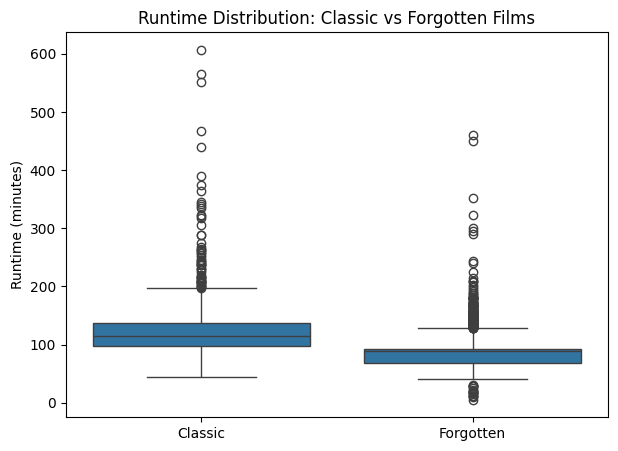

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=runtime_compare,
    x="group",
    y="runtimeMinutes"
)

plt.ylabel("Runtime (minutes)")
plt.xlabel("")
plt.title("Runtime Distribution: Classic vs Forgotten Films")
plt.show()



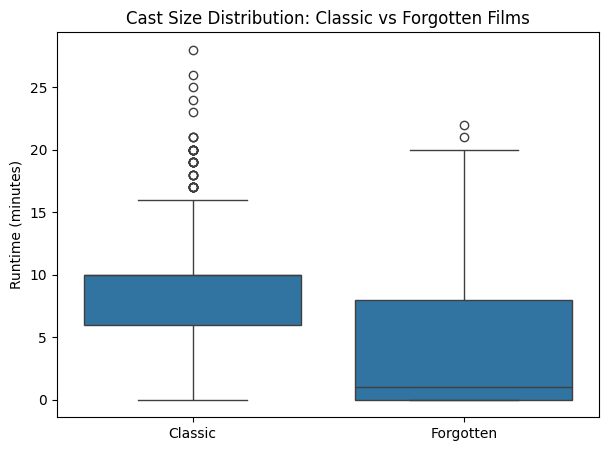

In [ ]:
cast_compare = pd.concat([
    Classic[["cast_size"]].assign(group="Classic"),
    Forgotten[["cast_size"]].assign(group="Forgotten")
])

plt.figure(figsize=(7,5))
sns.boxplot(
    data=cast_compare,
    x="group",
    y="cast_size"
)

plt.ylabel("Runtime (minutes)")
plt.xlabel("")
plt.title("Cast Size Distribution: Classic vs Forgotten Films")
plt.show()

In [ ]:
films["num_genres"] = films["genres"].fillna("").str.split(",").str.len()



In [ ]:
Classic = films[(films["averageRating"] >= 7.5) & (films["numVotes"] >= 782)]

Forgotten = films[(films["averageRating"] >= 7.5) & (films["numVotes"] <= 9)]



In [ ]:
Classic.columns


Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'num_directors', 'cast_size', 'runtime_missing', 'has_genre_info',
       'num_genres'],
      dtype='object')

In [ ]:
genre_count_compare = pd.DataFrame({
    "num_genres": pd.concat([
        Classic["num_genres"],
        Forgotten["num_genres"]
    ], ignore_index=True),
    "group": (
        ["Classic"] * len(Classic) +
        ["Forgotten"] * len(Forgotten)
    )
})



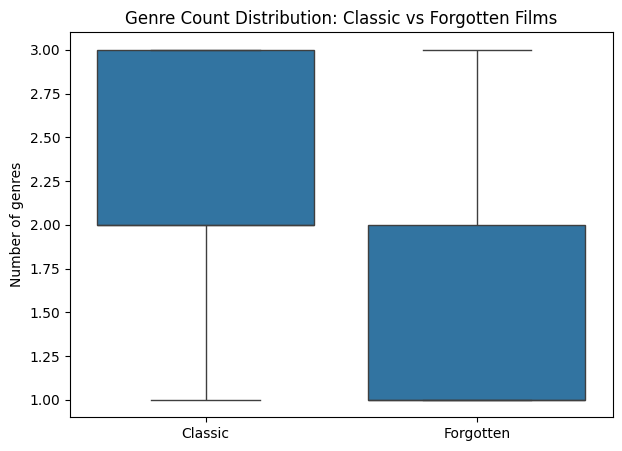

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=genre_count_compare,
    x="group",
    y="num_genres"
)

plt.ylabel("Number of genres")
plt.xlabel("")
plt.title("Genre Count Distribution: Classic vs Forgotten Films")
plt.show()


Classic films exhibit longer runtimes and greater genre diversity than forgotten films, suggesting that structural complexity may play a role in long term audience engagement. Furthermore we can confirm the idea that a greater general cast size has a role in extending the length of a film due to an expanded list of characters.

The analysis focuses on the more extreme outcomes, movies that either achieved sustained audience engagement or failed to do so. This naturally reduces the sample size by a fair bit but sharpens contrasts.